In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

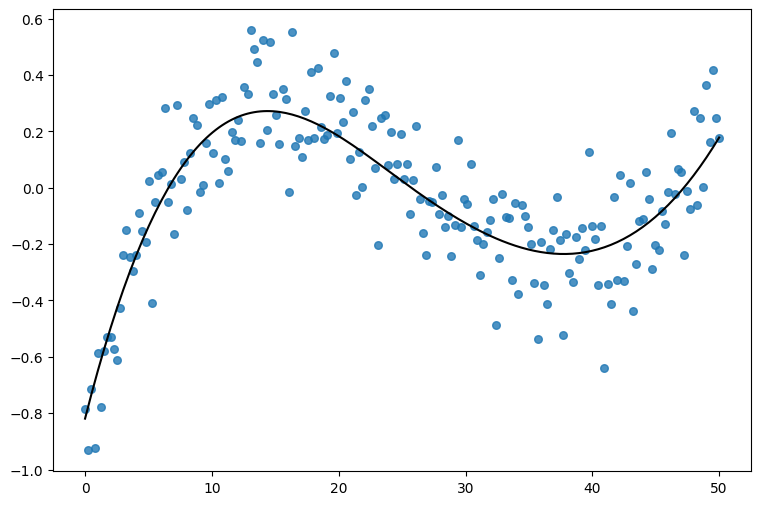

In [2]:
rng = np.random.default_rng(seed=121195)

N = 200
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=5)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=5, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [3]:
df = pd.DataFrame({"x": x, "y": y})
m = [10]
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1),
    "input_dim": 1
}
priors = {"hsgp(x, m = m, c = 2, centered = True)": prior_hsgp}
model = bmb.Model("y ~ 0 + hsgp(x, m = m, c = 2, centered = True)", df, priors=priors)
model.set_alias({"hsgp(x, m = m, c = 2, centered = True)": "hsgp"})

       Formula: y ~ 0 + hsgp(x, m = m, c = 2, centered = True)
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        HSGP effects
            hsgp(x, m = m, c = 2, centered = True) ~ HSGP
        
        Auxiliary parameters
            y_sigma ~ HalfStudentT(nu: 4.0, sigma: 0.2834)

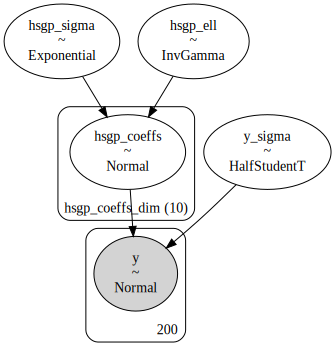

In [4]:
model.build()
model.graph()

In [5]:
idata = model.fit(inference_method="nuts_numpyro")

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:04.246477
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:08.298106
Transforming variables...
Transformation time =  0:00:00.023899


In [6]:
# hsgp_term = model.backend.components["y"].terms["hsgp(x, m = m, c = 2, centered = True)"]
# import xarray as xr
# to_stack_dims = ("chain", "draw")
# X_new = df["x"].to_numpy()[:, None]
# phi, sqrt_psd = hsgp_term.hsgp.prior_components(X_new)
# phi = phi.eval()
# sqrt_psd = sqrt_psd.eval()

# phi = xr.DataArray(phi, dims=("y_obs", "hsgp_coeffs_dim"))
# sqrt_psd = xr.DataArray(sqrt_psd, dims=("hsgp_coeffs_dim"))
# coeffs = idata.posterior["hsgp_coeffs"]

# phi, sqrt_psd = self.hsgp.prior_components(data)
# if self.term.centered:
#     return phi @ coeffs
# else:
#     return phi @ (coeffs * sqrt_psd)

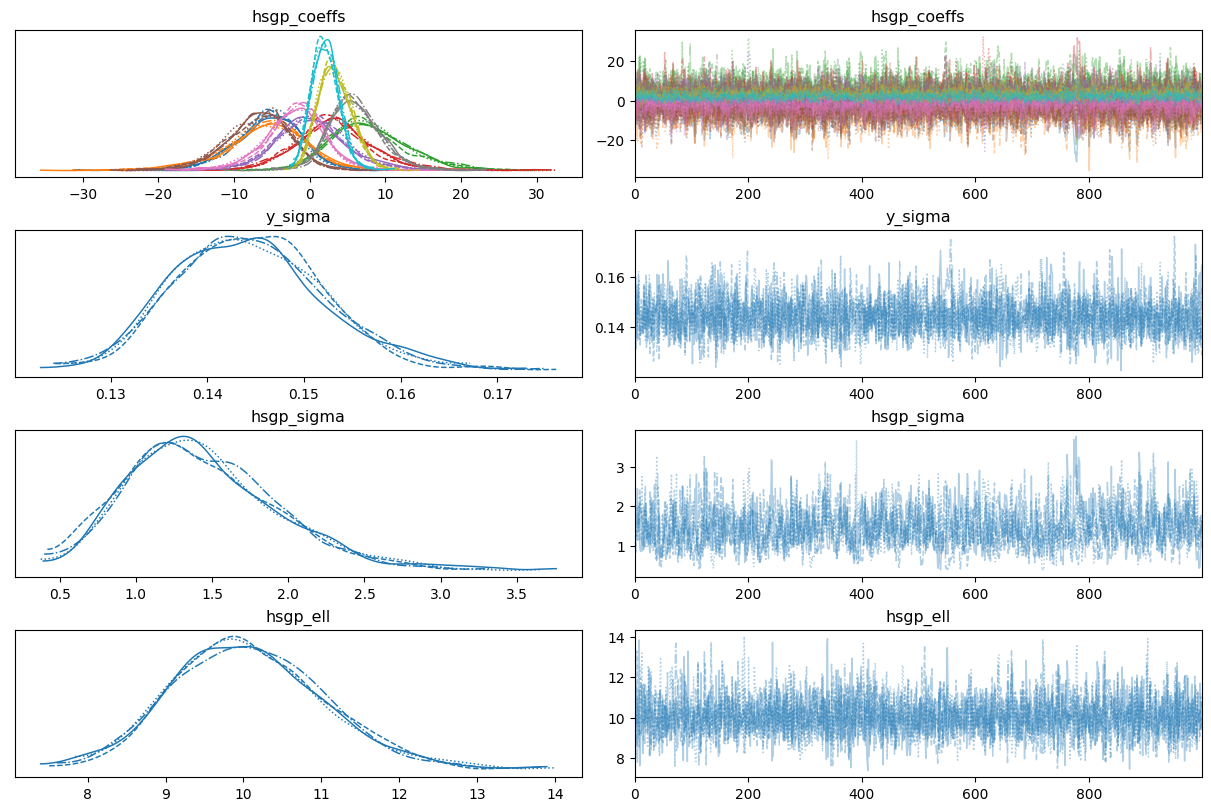

In [7]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

In [8]:
model.predict(idata)

In [14]:
from bambi.plots import plot_cap

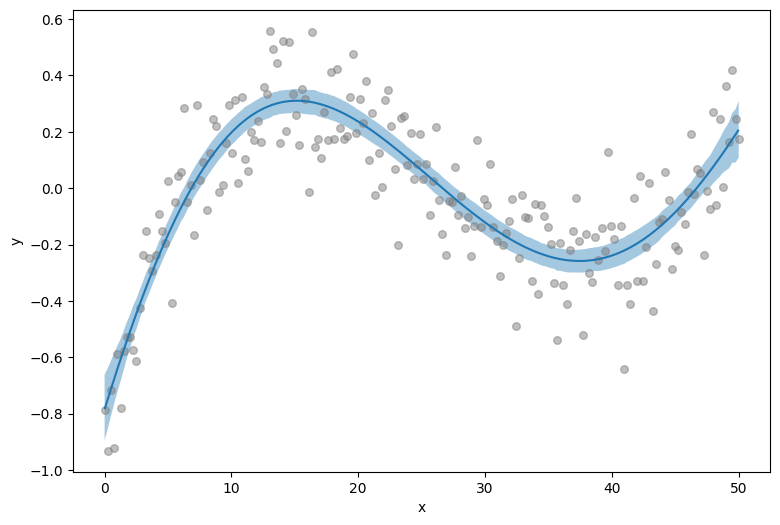

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))

plot_cap(model, idata, "x", ax=ax)
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5);